In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import scipy.io

In [2]:
# Here I used Colab, I needed this to access my drive file
# I strongly suggest to do the same if you plan to train from scratch
# Add the extracted dataset folder (jpg) in the same folder of the other files!
# You can download the dataset archive here: www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Design Dataset

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class DatasetFLOWERS(Dataset):

  def __init__(self, data, labels, setid, train=True, transform=None):
    super().__init__()
    self.data = data

    temp = scipy.io.loadmat(setid)
    trnid = np.array(temp['trnid'][0]).astype('int')
    tstid = np.array(temp['tstid'][0]).astype('int')
    val = np.array(temp['valid'][0]).astype('int')
    print(f'trnid: {trnid}, {trnid.shape}')
    print(f'val: {val}, {val.shape}')
    print(f'tstid: {tstid}, {tstid.shape}')
    trnid = np.hstack((trnid, val))
    trn, tst = torch.from_numpy(trnid), torch.from_numpy(tstid)

    temp = np.array(scipy.io.loadmat(DATA_LABELS)['labels'][0]).astype('int')
    print(f'labels: {temp}, {temp.shape}')
    self.labels = torch.from_numpy(temp)
    self.sids = trn if train is True else tst
    self.transform = transform
    
    # labels_idx = trn.tolist() if train is True else tst.tolist()


  def __len__(self):
    return len(self.sids)

  def __getitem__(self, index):
    # load image as ndarray type (H*W*C)
    index = self.sids[index]
    path = self.data + f'/image_{index:05d}.jpg'
    image = Image.open(path)
    tensor = self.transform(image)
    label = self.labels[index - 1] - 1
    return tensor, label


In [5]:
import matplotlib.pyplot as plt

ROOT_PATH = 'gdrive/My Drive/Colab Notebooks/Flowers' # USE YOUR OWN PATH ON DRIVE!
DATA = ROOT_PATH + '/jpg'
DATA_LABELS = ROOT_PATH + '/imagelabels.mat'
DATA_SETID = ROOT_PATH + '/setid.mat'
BATCH_SIZE = 4

transformTrain = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomResizedCrop(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transformTest = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainSet = DatasetFLOWERS(DATA, DATA_LABELS, DATA_SETID, train=True, transform=transformTrain)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=BATCH_SIZE, shuffle=True)

testSet = DatasetFLOWERS(DATA, DATA_LABELS, DATA_SETID, train=False, transform=transformTest)

testLoader = torch.utils.data.DataLoader(testSet, batch_size=BATCH_SIZE, shuffle=True)


trnid: [6765 6755 6768 ... 8026 8036 8041], (1020,)
val: [6773 6767 6739 ... 8028 8008 8030], (1020,)
tstid: [6734 6735 6737 ... 8044 8045 8047], (6149,)
labels: [77 77 77 ... 62 62 62], (8189,)
trnid: [6765 6755 6768 ... 8026 8036 8041], (1020,)
val: [6773 6767 6739 ... 8028 8008 8030], (1020,)
tstid: [6734 6735 6737 ... 8044 8045 8047], (6149,)
labels: [77 77 77 ... 62 62 62], (8189,)


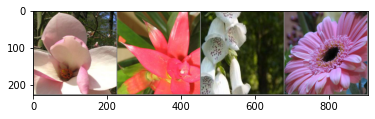

In [6]:
import matplotlib.pyplot as plt

# func to plot image
def imgshow(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get some random training images
dataiter = iter(trainLoader)  
images, labels = dataiter.next()  # This will give a batch_size of images

imgshow(torchvision.utils.make_grid(images))

# Define CNN

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 4, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        #self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1)
        self.fc1 = nn.Linear(64 * 5 * 5, 800)
        self.fc2 = nn.Linear(800, 102)

        #self.conv1 = nn.Conv2d(3, 6, 10, stride=2)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 16, 6, stride=2)
        #self.conv3 = nn.Conv2d(16, 40, 5, stride=3)
        #self.fc1 = nn.Linear(40 * 3 * 3, 120)
        #self.fc2 = nn.Linear(120, 102)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (98, 98)
        x = self.pool(F.relu(self.conv2(x)))  # (22, 22)
        x = self.pool(F.relu(self.conv3(x)))  # (8, 8)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=102, bias=True)
)


# Loss Function and Optimizer

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)

decayRate = 0.96
LRscheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


# Train Network

In [9]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    tot_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        tot_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
    LRscheduler.step()
    
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,   100] loss: 4.624
[1,   200] loss: 4.627
[1,   300] loss: 4.624
[1,   400] loss: 4.627
[1,   500] loss: 4.623
Adjusting learning rate of group 0 to 9.6000e-04.
[2,   100] loss: 4.615
[2,   200] loss: 4.614
[2,   300] loss: 4.593
[2,   400] loss: 4.553
[2,   500] loss: 4.526
Adjusting learning rate of group 0 to 9.2160e-04.
[3,   100] loss: 4.477
[3,   200] loss: 4.451
[3,   300] loss: 4.418
[3,   400] loss: 4.384
[3,   500] loss: 4.325
Adjusting learning rate of group 0 to 8.8474e-04.
[4,   100] loss: 4.255
[4,   200] loss: 4.314
[4,   300] loss: 4.238
[4,   400] loss: 4.232
[4,   500] loss: 4.210
Adjusting learning rate of group 0 to 8.4935e-04.
[5,   100] loss: 4.181
[5,   200] loss: 4.125
[5,   300] loss: 4.111
[5,   400] loss: 4.084
[5,   500] loss: 4.050
Adjusting learning rate of group 0 to 8.1537e-04.
[6,   100] loss: 3.914
[6,   200] loss: 3.941
[6,   300] loss: 3.893
[6,   400] loss: 3.927
[6,   500] loss: 3.923
Adjusting learning rate of group 0 to 7.8276e-04.
[7,   100]

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Check results on Test Set

In [11]:
# Let's look at the performances on the whole dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        #print(f'predicted:{predicted}, label:{labels}')
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testSet)} test images: %.2f %%' % (
    100 * float(correct / total)))

Accuracy of the network on the 6149 test images: 39.52 %


# Check result on Train Test


In [12]:
# Let's look at the performances on the whole dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainLoader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        #print(f'predicted:{predicted}, label:{labels}')
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(trainSet)} train images: %.2f %%' % (
    100 * float(correct / total)))

Accuracy of the network on the 2040 train images: 54.56 %


In [13]:
# Let's see how the model performed on the single classes

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in np.unique(testSet.labels).astype('int')-1}
total_pred = {classname: 0 for classname in np.unique(testSet.labels).astype('int')-1}
#print( np.unique(testSet.labels).astype('int'))
correct_pred[0] = 0
total_pred[0] = 0

# again no gradients needed
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] != 0:
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {} is: {:.1f} %".format(classname,
                                                   accuracy))
    else:
      print("Accuracy for class {} is: {:.1f} %".format(classname,
                                                   0.0))

Accuracy for class 0 is: 55.0 %
Accuracy for class 1 is: 80.0 %
Accuracy for class 2 is: 5.0 %
Accuracy for class 3 is: 8.3 %
Accuracy for class 4 is: 33.3 %
Accuracy for class 5 is: 64.0 %
Accuracy for class 6 is: 35.0 %
Accuracy for class 7 is: 75.4 %
Accuracy for class 8 is: 61.5 %
Accuracy for class 9 is: 88.0 %
Accuracy for class 10 is: 7.5 %
Accuracy for class 11 is: 58.2 %
Accuracy for class 12 is: 89.7 %
Accuracy for class 13 is: 75.0 %
Accuracy for class 14 is: 69.0 %
Accuracy for class 15 is: 19.0 %
Accuracy for class 16 is: 55.4 %
Accuracy for class 17 is: 4.8 %
Accuracy for class 18 is: 41.4 %
Accuracy for class 19 is: 19.4 %
Accuracy for class 20 is: 65.0 %
Accuracy for class 21 is: 35.9 %
Accuracy for class 22 is: 59.2 %
Accuracy for class 23 is: 68.2 %
Accuracy for class 24 is: 33.3 %
Accuracy for class 25 is: 52.4 %
Accuracy for class 26 is: 40.0 %
Accuracy for class 27 is: 65.2 %
Accuracy for class 28 is: 44.8 %
Accuracy for class 29 is: 18.5 %
Accuracy for class 30 is